In [65]:
import pandas as pd
import numpy as np
from numpy import argmax

from datetime import date, time, timedelta
import pendulum

import matplotlib.pyplot as plt
import seaborn as sns

import category_encoders as ce

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score, precision_recall_curve, recall_score, f1_score, precision_recall_curve

In [66]:
df = pd.read_csv("orders_with_fraudulent.csv")

In [67]:
df = df.drop(['created_at', 'experience_date' ], axis=1)
df.head()

,order_id,city,category_name,product_id,product_name,amount,device,payment_id,payment_method,payment_method_provider,payment_method_bin,payment_method_type,payment_method_product,payment_method_card_category,payment_method_issuer_bank,payment_method_issue_country,is_fraudulent,time_diff
0,ORD146730,Berlin,Food,PID47730,Shirt,1755.46,Tablet,PAY246730,Debit Card,RuPay,909128,Card,Basic,Platinum,HDFC,JP,0,3571
1,ORD148393,Mumbai,Entertainment,PID49393,Pizza,1862.22,Mobile,PAY248393,Credit Card,PayPal,824286,Card,Standard,Silver,HDFC,JP,0,162
2,ORD141416,New York,Electronics,PID42416,Concert Ticket,330.92,Mobile,PAY241416,Debit Card,Amex,158875,Card,Basic,Silver,SBI,DE,0,3058
3,ORD134506,Mumbai,Clothing,PID35506,Shirt,364.06,Tablet,PAY234506,UPI,RuPay,893992,Wallet,Premium,Silver,CitiBank,DE,0,793
4,ORD143725,Mumbai,Food,PID44725,Laptop,452.68,Desktop,PAY243725,PayPal,MasterCard,688671,Wallet,Standard,Silver,HDFC,IN,0,3027


In [69]:
df['is_fraudulent'].value_counts()

is_fraudulent
0    19618
1      382
Name: count, dtype: int64

In [36]:
df['is_fraudulent'].value_counts(normalize=True)

is_fraudulent
0    0.9809
1    0.0191
Name: proportion, dtype: float64

In [70]:
df.columns

Index(['order_id', 'city', 'category_name', 'product_id', 'product_name',
       'amount', 'device', 'payment_id', 'payment_method',
       'payment_method_provider', 'payment_method_bin', 'payment_method_type',
       'payment_method_product', 'payment_method_card_category',
       'payment_method_issuer_bank', 'payment_method_issue_country',
       'is_fraudulent', 'time_diff'],
      dtype='object')

In [71]:
df.nunique()

order_id                        20000
city                                5
category_name                       5
product_id                      20000
product_name                        5
amount                          19020
device                              3
payment_id                      20000
payment_method                      5
payment_method_provider             5
payment_method_bin              19762
payment_method_type                 3
payment_method_product              3
payment_method_card_category        3
payment_method_issuer_bank          5
payment_method_issue_country        5
is_fraudulent                       2
time_diff                        3585
dtype: int64

In [73]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 18 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   order_id                      20000 non-null  object 
 1   city                          20000 non-null  object 
 2   category_name                 20000 non-null  object 
 3   product_id                    20000 non-null  object 
 4   product_name                  20000 non-null  object 
 5   amount                        20000 non-null  float64
 6   device                        20000 non-null  object 
 7   payment_id                    20000 non-null  object 
 8   payment_method                20000 non-null  object 
 9   payment_method_provider       20000 non-null  object 
 10  payment_method_bin            20000 non-null  int64  
 11  payment_method_type           20000 non-null  object 
 12  payment_method_product        20000 non-null  object 
 13  p

In [74]:
if df.shape[0] == df.drop_duplicates().shape[0]:
    print("No Duplicates")  
else:
    duplicates = df.shape[0] - df.drop_duplicates().shape[0]
    print(f"Number of duplicate rows: {duplicates}")

No Duplicates


In [76]:
df.columns


Index(['order_id', 'city', 'category_name', 'product_id', 'product_name',
       'amount', 'device', 'payment_id', 'payment_method',
       'payment_method_provider', 'payment_method_bin', 'payment_method_type',
       'payment_method_product', 'payment_method_card_category',
       'payment_method_issuer_bank', 'payment_method_issue_country',
       'is_fraudulent', 'time_diff'],
      dtype='object')

In [78]:
df = df.drop(['order_id', 'payment_id', 'payment_method', 'product_name', 'payment_method_bin'], axis=1)

In [75]:
df.isna().sum()

order_id                        0
city                            0
category_name                   0
product_id                      0
product_name                    0
amount                          0
device                          0
payment_id                      0
payment_method                  0
payment_method_provider         0
payment_method_bin              0
payment_method_type             0
payment_method_product          0
payment_method_card_category    0
payment_method_issuer_bank      0
payment_method_issue_country    0
is_fraudulent                   0
time_diff                       0
dtype: int64

In [44]:
df = df.dropna(axis=0, how='any', subset=['payment_method_card_category', 'payment_method_issuer_bank','payment_method_issue_country', 'payment_method_product'])

In [45]:
df.head()

,city,category_name,product_id,product_name,amount,device,payment_id,payment_method,payment_method_provider,payment_method_bin,payment_method_type,payment_method_product,payment_method_card_category,payment_method_issuer_bank,payment_method_issue_country,is_fraudulent,time_diff
0,Berlin,Food,PID47730,Shirt,1755.46,Tablet,PAY246730,Debit Card,RuPay,909128,Card,Basic,Platinum,HDFC,JP,0,3571
1,Mumbai,Entertainment,PID49393,Pizza,1862.22,Mobile,PAY248393,Credit Card,PayPal,824286,Card,Standard,Silver,HDFC,JP,0,162
2,New York,Electronics,PID42416,Concert Ticket,330.92,Mobile,PAY241416,Debit Card,Amex,158875,Card,Basic,Silver,SBI,DE,0,3058
3,Mumbai,Clothing,PID35506,Shirt,364.06,Tablet,PAY234506,UPI,RuPay,893992,Wallet,Premium,Silver,CitiBank,DE,0,793
4,Mumbai,Food,PID44725,Laptop,452.68,Desktop,PAY243725,PayPal,MasterCard,688671,Wallet,Standard,Silver,HDFC,IN,0,3027


In [46]:
df['is_fraudulent'].value_counts(normalize=True)

is_fraudulent
0    0.9809
1    0.0191
Name: proportion, dtype: float64

In [79]:
for column in list(df.columns):
    if df[column].dtype == 'object':
        if len(df[f"{column}"].unique()) == len(df[f"{column}"].apply(lambda x: x.lower()).unique()):
            print(f"no string duplicates in {column}")
        else:
            print(f"string duplicates in {column}")

no string duplicates in city
no string duplicates in category_name
no string duplicates in product_id
no string duplicates in device
no string duplicates in payment_method_provider
no string duplicates in payment_method_type
no string duplicates in payment_method_product
no string duplicates in payment_method_card_category
no string duplicates in payment_method_issuer_bank
no string duplicates in payment_method_issue_country


In [81]:
X = df.drop('is_fraudulent', axis=1)
y = df['is_fraudulent']

In [83]:
X = X.drop(['payment_method_card_category'], axis=1)

In [84]:
# labelencoding is use for the categorical features when low cardinality
le = LabelEncoder()
X['city'] = le.fit_transform(X['city'])
X['payment_method_issue_country'] = le.fit_transform(X['payment_method_issue_country'])
y = le.fit_transform(y)

In [85]:
# Target mean encoding the categorical features use when high cardinality
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)

In [86]:
X_train.shape

(16000, 11)

In [87]:
X_train.columns

Index(['city', 'category_name', 'product_id', 'amount', 'device',
       'payment_method_provider', 'payment_method_type',
       'payment_method_product', 'payment_method_issuer_bank',
       'payment_method_issue_country', 'time_diff'],
      dtype='object')

In [88]:
# Target mean encoding
ce_target = ce.TargetEncoder(cols=['product_id', 'device', 'category_name', 'payment_method_issue_country', 'payment_method_provider', 'payment_method_type', 'payment_method_issuer_bank', 'payment_method_product'])
X_train = ce_target.fit_transform(X_train, y_train)
X_test = ce_target.transform(X_test)

In [89]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16000 entries, 15067 to 9036
Data columns (total 11 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   city                          16000 non-null  int64  
 1   category_name                 16000 non-null  float64
 2   product_id                    16000 non-null  float64
 3   amount                        16000 non-null  float64
 4   device                        16000 non-null  float64
 5   payment_method_provider       16000 non-null  float64
 6   payment_method_type           16000 non-null  float64
 7   payment_method_product        16000 non-null  float64
 8   payment_method_issuer_bank    16000 non-null  float64
 9   payment_method_issue_country  16000 non-null  float64
 10  time_diff                     16000 non-null  int64  
dtypes: float64(9), int64(2)
memory usage: 1.5 MB


In [90]:
continuous_columns = ['amount', 'time_diff']

In [91]:
numerical_features = [df.columns.get_loc(c) for c in continuous_columns if c in X_train.columns]

In [92]:
sc = StandardScaler()
continuous_columns = ['amount', 'time_diff']
# only keep columns that actually exist in X_train after encoding
cols_to_scale = [c for c in continuous_columns if c in X_train.columns]
if cols_to_scale:
    X_train[cols_to_scale] = sc.fit_transform(X_train[cols_to_scale])
    X_test[cols_to_scale] = sc.transform(X_test[cols_to_scale])

In [93]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate

In [94]:
model = LogisticRegression()
scores = cross_validate(model, X_train, y_train, cv=3, scoring=['accuracy', 'precision', 'recall', 'f1'], return_train_score=True)

c:\Users\Sangram pc\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Sangram pc\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Sangram pc\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mod

In [95]:
results = pd.DataFrame(scores)

In [96]:
results

,fit_time,score_time,test_accuracy,train_accuracy,test_precision,train_precision,test_recall,train_recall,test_f1,train_f1
0,0.025998,0.011002,0.980877,0.980874,0.0,0.0,0.0,0.0,0.0,0.0
1,0.022635,0.007001,0.980874,0.980876,0.0,0.0,0.0,0.0,0.0,0.0
2,0.018894,0.007013,0.980874,0.980876,0.0,0.0,0.0,0.0,0.0,0.0


In [97]:
from sklearn.metrics import confusion_matrix, classification_report


In [98]:
model.fit(X_train, y_train)
confusionMatrix = confusion_matrix(y_test, model.predict(X_test))
print(confusionMatrix)

[[3924    0]
 [  76    0]]


In [99]:
print(classification_report(y_test, model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      3924
           1       0.00      0.00      0.00        76

    accuracy                           0.98      4000
   macro avg       0.49      0.50      0.50      4000
weighted avg       0.96      0.98      0.97      4000



c:\Users\Sangram pc\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Sangram pc\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Sangram pc\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


In [100]:
tp = float(confusionMatrix[1, 1])
tn = float(confusionMatrix[0, 0])   
fp = float(confusionMatrix[0, 1])
fn = float(confusionMatrix[1, 0])

In [101]:
spec = tn / (tn + fp)
sens = tp / (tp + fn)

In [102]:
g_mean = (spec * sens) ** 0.5
g_mean

0.0

In [104]:
from imblearn.under_sampling import RandomUnderSampler

In [105]:
rus = RandomUnderSampler(random_state=0)
X_res, y_res = rus.fit_resample(X_train, y_train)

In [106]:
print(X_res.shape)

(612, 11)


In [107]:
print(y_res[y_res==1].shape, y_res[y_res==0].shape)

(306,) (306,)


In [108]:
mets = ['accuracy', 'precision', 'recall', 'f1']
scores = cross_validate(model, X_res, y_res, cv=5, scoring=mets, return_train_score=True)

In [109]:
scores

{'fit_time': array([0.0089972 , 0.00699401, 0.00599957, 0.00800037, 0.00520873]),
 'score_time': array([0.0130055 , 0.0090003 , 0.00799823, 0.00700355, 0.00501657]),
 'test_accuracy': array([1., 1., 1., 1., 1.]),
 'train_accuracy': array([1., 1., 1., 1., 1.]),
 'test_precision': array([1., 1., 1., 1., 1.]),
 'train_precision': array([1., 1., 1., 1., 1.]),
 'test_recall': array([1., 1., 1., 1., 1.]),
 'train_recall': array([1., 1., 1., 1., 1.]),
 'test_f1': array([1., 1., 1., 1., 1.]),
 'train_f1': array([1., 1., 1., 1., 1.])}

[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 1 1 ... 0 1 0]
[1 1 1 ... 1 1 1]
[1 1 1 ... 1 1 1]


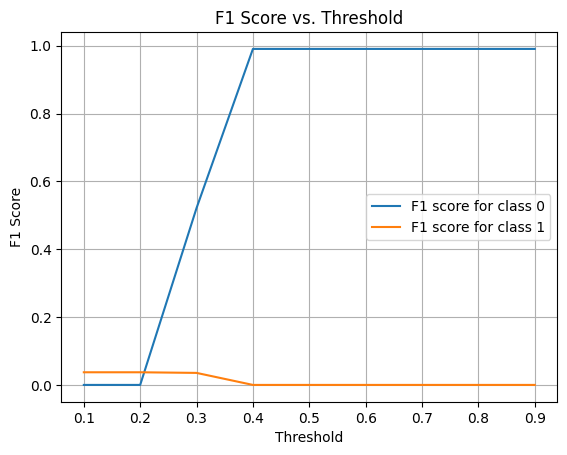

In [114]:
model.fit(X_res, y_res)
prob = model.predict_proba(X_test)[:, 1]

f1_0, f1_1 = [], []
thresholds = [0.9,0.8,0.7,0.6,0.5,0.4,0.3,0.2,0.1]

for t in thresholds:
    y_pred = (prob >= t).astype(int)
    print(y_pred)
    f1_0.append(f1_score(y_test, y_pred, pos_label=0))
    f1_1.append(f1_score(y_test, y_pred, pos_label=1))

plt.plot(thresholds, f1_0, label='F1 score for class 0')
plt.plot(thresholds, f1_1, label='F1 score for class 1')
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.title('F1 Score vs. Threshold')
plt.legend()
plt.grid()
plt.show()


In [118]:
test_prob = model.predict_proba(X_test)[:, 1]
preds = np.where(test_prob >= 0.3, 1, 0)
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.98      0.36      0.52      3924
           1       0.02      0.62      0.04        76

    accuracy                           0.36      4000
   macro avg       0.50      0.49      0.28      4000
weighted avg       0.96      0.36      0.51      4000



In [119]:
from imblearn.under_sampling import TomekLinks
from collections import Counter

In [120]:
tom = TomekLinks()
X_tom, y_tom = tom.fit_resample(X_train, y_train)

In [121]:
print("Resampled dataset shape:", Counter(y_tom))

Resampled dataset shape: Counter({np.int64(0): 15694, np.int64(1): 306})


In [122]:
scores_tom = cross_validate(model, X_tom, y_tom, cv=5, scoring=mets, return_train_score=True)
pd.DataFrame(scores_tom)

c:\Users\Sangram pc\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Sangram pc\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Sangram pc\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mod

,fit_time,score_time,test_accuracy,train_accuracy,test_precision,train_precision,test_recall,train_recall,test_f1,train_f1
0,0.036801,0.013998,0.980938,0.980859,0.0,0.0,0.0,0.0,0.0,0.0
1,0.027255,0.010123,0.980938,0.980859,0.0,0.0,0.0,0.0,0.0,0.0
2,0.057335,0.010979,0.980938,0.980859,0.0,0.0,0.0,0.0,0.0,0.0
3,0.019182,0.007999,0.980938,0.980859,0.0,0.0,0.0,0.0,0.0,0.0
4,0.027009,0.010993,0.980625,0.980938,0.0,0.0,0.0,0.0,0.0,0.0


In [123]:
model.fit(X_tom, y_tom)
print(classification_report(y_tom, model.predict(X_tom)))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99     15694
           1       0.00      0.00      0.00       306

    accuracy                           0.98     16000
   macro avg       0.49      0.50      0.50     16000
weighted avg       0.96      0.98      0.97     16000



c:\Users\Sangram pc\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Sangram pc\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Sangram pc\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


In [124]:
print(classification_report(y_test, model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      3924
           1       0.00      0.00      0.00        76

    accuracy                           0.98      4000
   macro avg       0.49      0.50      0.50      4000
weighted avg       0.96      0.98      0.97      4000



c:\Users\Sangram pc\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Sangram pc\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Sangram pc\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


In [125]:
from imblearn.over_sampling import SMOTE

smt = SMOTE()
X_smt, y_smt = smt.fit_resample(X_train, y_train)
print("Resampled dataset shape:", Counter(y_smt))

Resampled dataset shape: Counter({np.int64(0): 15694, np.int64(1): 15694})


In [126]:
scores_smt = cross_validate(model, X_smt, y_smt, cv=5, scoring=mets, return_train_score=True)
pd.DataFrame(scores_smt)

,fit_time,score_time,test_accuracy,train_accuracy,test_precision,train_precision,test_recall,train_recall,test_f1,train_f1
0,0.045008,0.008996,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,0.042011,0.013990,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,0.061997,0.007003,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3,0.043168,0.012019,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,0.037636,0.007973,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [128]:
model.fit(X_smt, y_smt)
print(classification_report(y_smt, model.predict(X_smt)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     15694
           1       1.00      1.00      1.00     15694

    accuracy                           1.00     31388
   macro avg       1.00      1.00      1.00     31388
weighted avg       1.00      1.00      1.00     31388



In [129]:
print(classification_report(y_test, model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      3924
           1       0.00      0.00      0.00        76

    accuracy                           0.98      4000
   macro avg       0.49      0.50      0.50      4000
weighted avg       0.96      0.98      0.97      4000



c:\Users\Sangram pc\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Sangram pc\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Sangram pc\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


In [ ]:
from imblearn.over_sampling import ADASYN

# sampling_strategy is parameter that defines the desired ratio of the number of samples in the minority class to the number of samples in the majority class after resampling. For example, a sampling_strategy of 0.3 means that the minority class will have 30% of the number of samples in the majority class after resampling.
ada = ADASYN(sampling_strategy=0.3)
X_ada, y_ada = ada.fit_resample(X_train, y_train)
print("Resampled dataset shape:", Counter(y_ada))

Resampled dataset shape: Counter({np.int64(0): 15694, np.int64(1): 4626})


In [132]:
scores_ada = cross_validate(model, X_ada, y_ada, cv=5, scoring=mets, return_train_score=True)
pd.DataFrame(scores_ada)

,fit_time,score_time,test_accuracy,train_accuracy,test_precision,train_precision,test_recall,train_recall,test_f1,train_f1
0,0.043328,0.011998,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,0.042279,0.011995,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,0.045420,0.007996,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3,0.021656,0.006017,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,0.028007,0.008001,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [133]:
test_prob = model.predict_proba(X_test)[:, 1]
preds = np.where(test_prob >= 0.4, 1, 0)
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      3924
           1       0.00      0.00      0.00        76

    accuracy                           0.98      4000
   macro avg       0.49      0.50      0.50      4000
weighted avg       0.96      0.98      0.97      4000



c:\Users\Sangram pc\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Sangram pc\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Sangram pc\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


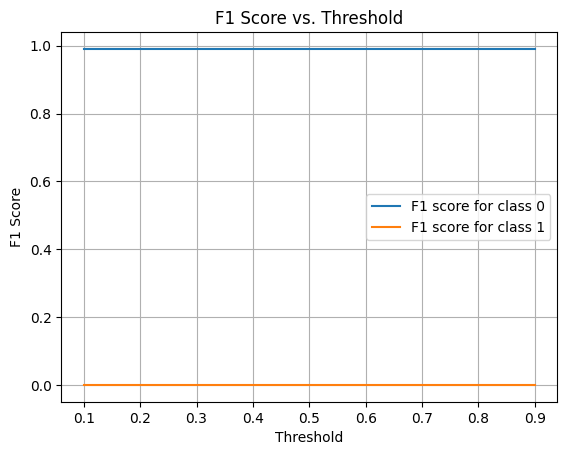

In [134]:

prob = model.predict_proba(X_test)[:, 1]

f1_0, f1_1 = [], []
thresholds = [0.9,0.8,0.7,0.6,0.5,0.4,0.3,0.2,0.1]

for t in thresholds:
    y_pred = (prob >= t).astype(int)
    print(y_pred)
    f1_0.append(f1_score(y_test, y_pred, pos_label=0))
    f1_1.append(f1_score(y_test, y_pred, pos_label=1))

plt.plot(thresholds, f1_0, label='F1 score for class 0')
plt.plot(thresholds, f1_1, label='F1 score for class 1')
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.title('F1 Score vs. Threshold')
plt.legend()
plt.grid()
plt.show()


In [135]:
from imblearn.combine import SMOTEENN

In [136]:
smenn = SMOTEENN()
X_smen, y_smen = smenn.fit_resample(X_train, y_train)
print("Resampled dataset shape:", Counter(y_smen))

Resampled dataset shape: Counter({np.int64(0): 15694, np.int64(1): 15615})


In [137]:
scores_smenn = cross_validate(model, X_smen, y_smen, cv=5, scoring=mets, return_train_score=True)
pd.DataFrame(scores_smenn)

,fit_time,score_time,test_accuracy,train_accuracy,test_precision,train_precision,test_recall,train_recall,test_f1,train_f1
0,0.063131,0.010056,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,0.033929,0.008012,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,0.047737,0.010008,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3,0.039104,0.009989,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,0.050985,0.013998,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [138]:
model.fit(X_smen, y_smen)
print(classification_report(y_test, model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      3924
           1       0.00      0.00      0.00        76

    accuracy                           0.98      4000
   macro avg       0.49      0.50      0.50      4000
weighted avg       0.96      0.98      0.97      4000



c:\Users\Sangram pc\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Sangram pc\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Sangram pc\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


In [139]:
from imblearn.combine import SMOTETomek

smtom = SMOTETomek()
X_smtom, y_smtom = smtom.fit_resample(X_train, y_train)
print("Resampled dataset shape:", Counter(y_smtom))

Resampled dataset shape: Counter({np.int64(0): 15694, np.int64(1): 15694})


In [140]:
scores_smtom = cross_validate(model, X_smtom, y_smtom, cv=5, scoring=mets, return_train_score=True)
pd.DataFrame(scores_smtom)

,fit_time,score_time,test_accuracy,train_accuracy,test_precision,train_precision,test_recall,train_recall,test_f1,train_f1
0,0.045396,0.015019,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,0.029581,0.007984,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,0.040020,0.009988,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3,0.031940,0.008408,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,0.035435,0.007997,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [141]:
model.fit(X_smtom, y_smtom)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


In [142]:
print(classification_report(y_test, model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      3924
           1       0.00      0.00      0.00        76

    accuracy                           0.98      4000
   macro avg       0.49      0.50      0.50      4000
weighted avg       0.96      0.98      0.97      4000



c:\Users\Sangram pc\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Sangram pc\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Sangram pc\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
